<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary-plots" data-toc-modified-id="Summary-plots-1">Summary plots</a></span><ul class="toc-item"><li><span><a href="#Quobyte" data-toc-modified-id="Quobyte-1.1">Quobyte</a></span></li><li><span><a href="#Pure-Storage" data-toc-modified-id="Pure-Storage-1.2">Pure Storage</a></span></li><li><span><a href="#Caringo" data-toc-modified-id="Caringo-1.3">Caringo</a></span></li></ul></li><li><span><a href="#Vendor-comparison-plots" data-toc-modified-id="Vendor-comparison-plots-2">Vendor comparison plots</a></span></li><li><span><a href="#Missing-Quobyte-data-investigation" data-toc-modified-id="Missing-Quobyte-data-investigation-3">Missing Quobyte data investigation</a></span><ul class="toc-item"><li><span><a href="#Exceptionally-slow-requests" data-toc-modified-id="Exceptionally-slow-requests-3.1">Exceptionally slow requests</a></span></li></ul></li></ul></div>

In [1]:
# Imports 
import re
import pathlib
import itertools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define some useful function

def MiB_to_Gb(val):
    return val*8*1024**2/10**9

def Gb_to_MiB(val):
    return val*10**9/(8*1024**2)

def parse_datetime(s: str):
    """Carefully parses the specific datetime string used by warp"""
    other, decimal = s.split('.')
    decimal_rounded = f"{float('0.'+decimal.rstrip('Z')):.6f}"[1:]
    return dt.datetime.strptime(other + decimal_rounded, '%Y-%m-%dT%H:%M:%S.%f')

def check_analysis_window(df):
    data = df[df.op == 'PUT']
    groups = data.groupby('thread')
    window_start =  groups.end.first().max()
    window_end = groups.start.last().min()
    window = window_end - window_start
    
    return {
        'total_upload_time': data.end.max() - data.start.min(),
        'useable_window': window if window_start < window_end else pd.Timedelta(0),
    }

def load_raw_data(results_file, check_error=True):
    """Load and preprocess raw benchmark data from `warp`"""
    df = pd.read_csv(results_file, sep="\t")
    # Separate out benchmark command
    warp_command = df.iloc[-1].idx
    df = df.iloc[:-1]
    # Drop some unused columns
    df = df.drop(['idx'], axis=1)
    if check_error:
        if df.error.isna().all():
            df = df.drop('error', axis=1)
        else:
            raise Exception("Errors found in df.error column")
    if df.n_objects.eq(1).all():
        df = df.drop('n_objects', axis=1)
    # Convert some data dtypes
    for col in ['start', 'end']:
        df[col] = df[col].map(parse_datetime)    
    return df, warp_command

def load_summary_data(filename):
    """Loads the summary csv data from `warp analyze ...` into a pandas dataframe"""
    df = pd.read_csv(filename, sep="\t")
    df = df[~(df.op == "op")]
    for col in ['mb_per_sec', 'objs_per_sec']:
        df[col] = pd.to_numeric(df[col])
    return df

def parse_text_summary(filename):
    """Parses the text summary from `warp analyze ...` and generates a dict of throughput values"""
    # Read input and compile reusable regexs
    op_regex = re.compile(r"[A-Z][A-Z]+")
    score_regex = re.compile(r"[0-9]+\.[0-9]+\ [a-zA-Z]+/s")
    with open(filename, "r") as file:
        lines = file.readlines()
    # Iterate through file lines and extract relevant pieces
    scores = {}
    current_op = None
    for line in lines:
        if line.startswith("Operation: "):
            op = op_regex.search(line)[0]
            current_op = op
            scores[op] = {}
        elif line.startswith(" * Throughput: ") or line.startswith("* Average:"):
            for score in score_regex.finditer(line):
                val, unit = score[0].split(" ")
                scores[current_op][unit] = float(val)
        elif line.startswith("Cluster Total: "):
            scores["Total"] = {}
            for score in score_regex.finditer(line):
                val, unit = score[0].split(" ")
                scores["Total"][unit] = float(val)
    # Convert obj/s to kIOPS
    for op in scores.keys():
        if 'obj/s' in scores[op].keys():
            val = scores[op].pop('obj/s')
            scores[op]['kIOPS'] = val / 1000
        
    return scores

## Summary plots

In [2]:
# Code 

def file_filter(file, vendor, op, nodes, threads, obj_size):
    pattern = f's3-summary.{vendor}-{op}-{nodes}-{threads}-{obj_size}-'
    return (pattern in file.name and file.suffix == '.txt')

def plot_single_vendor_summary(
    vendor, 
    op, 
    unit='MiB/s',
    ax=None,
    bar_colours=None,
    highlight_missing=True,
):
    
    # Load scores
    data_dir = pathlib.Path('./benchmark-runs/')
    scores = {}
    for nodes in [1, 2, 5]:
        for threads in [1, 20, 50, 100]:
            group_key = f'{nodes}-nodes\n{threads}-threads'
            scores[group_key] = {}
            for size in ['10KiB', '10MiB', '100MiB', '1GiB']:
                # Always use 'get' as op filter since this file also holds 'put' scores
                files = list(filter(
                    lambda f: file_filter(f, vendor, 'get', nodes, threads, size),
                    data_dir.iterdir()
                ))
                if len(files) > 1:
                    raise Exception(
                        f'Ambiguous file filter - {len(files)} files found for:',
                        vendor, 'get', nodes, threads, size,
                        '\nFiles:', files
                    )
                try:
                    scores[group_key][size] = parse_text_summary(files[0])[op.upper()]
                except Exception:
                    scores[group_key][size] = {'MiB/s': 0, 'kIOPS': 0}
                if unit not in scores[group_key][size].keys():
                    scores[group_key][size] = {unit: 0}                    
    
    # Wrangle data into plottable format
    groups = list(scores.keys())
    keys = [k for k, v in scores[groups[0]].items() if unit in v.keys()]
    data = {k:[scores[g][k][unit] for g in groups] for k in keys}

    x = np.arange(len(groups))  # the label locations
    width = 1 / (1+len(keys)) # the width of the bars
    multiplier = (1.5 - len(keys)/2)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.grid(axis="y", lw=0.5, zorder=0)
    
    missing_label_set = False
    for i, (k, scores) in enumerate(data.items()):
        offset = width * multiplier
        rects = ax.bar(
            x + offset, 
            scores, 
            width, 
            ec="k", 
            label=k, 
            zorder=3,
            color=(bar_colours[k] if bar_colours is not None else None)
        )
        multiplier += 1
        # Add temporary marker for missing data
        if highlight_missing:
            for i, s in enumerate(scores):
                if s == 0:
                    L = 'Missing data' if not missing_label_set else ''
                    ax.axvline([i+offset], lw=5, c='grey', alpha=0.5, label=L)
                    missing_label_set = True


    # Add some extra stuff
    ax.set_xticks(x + width, groups)
    ax.set_ylabel(unit)
    ax.legend(title='File size:', loc=2)
    if unit == 'MiB/s':
        ax.axhline([Gb_to_MiB(50)], label='Single node limit (2x25 Gbps)', c='grey', ls='--')
        # Create second axis with Gbps units
        ax2 = ax.twinx()
        ax2.set_ylim(tuple(map(MiB_to_Gb, ax.get_ylim())))
        ax2.set_ylabel('Gbps')
        
    return ax

### Quobyte 

File size throughput:

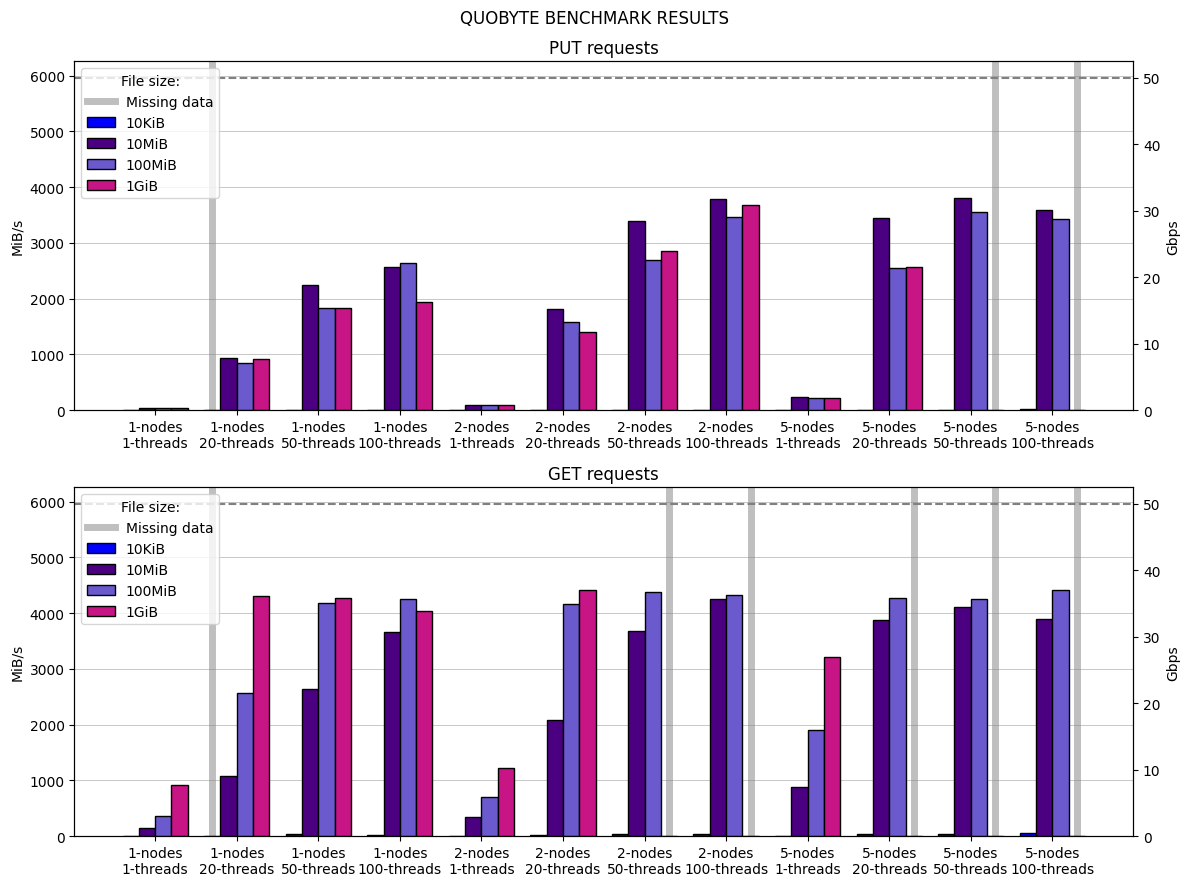

In [3]:
# Code 
vendor = 'quobyte'
fig, axs = plt.subplots(figsize=(12, 9), nrows=2)
fig.suptitle(f'{vendor} benchmark results'.upper())
bar_colours = {"10KiB":"blue", "10MiB":"indigo", "100MiB":"slateblue", "1GiB":"mediumvioletred"}
axs[0].set_title('PUT requests')
plot_single_vendor_summary(vendor, 'put', ax=axs[0], bar_colours=bar_colours)
axs[1].set_title('GET requests')
plot_single_vendor_summary(vendor, 'get', ax=axs[1], bar_colours=bar_colours)

plt.tight_layout()

Object count throughput:

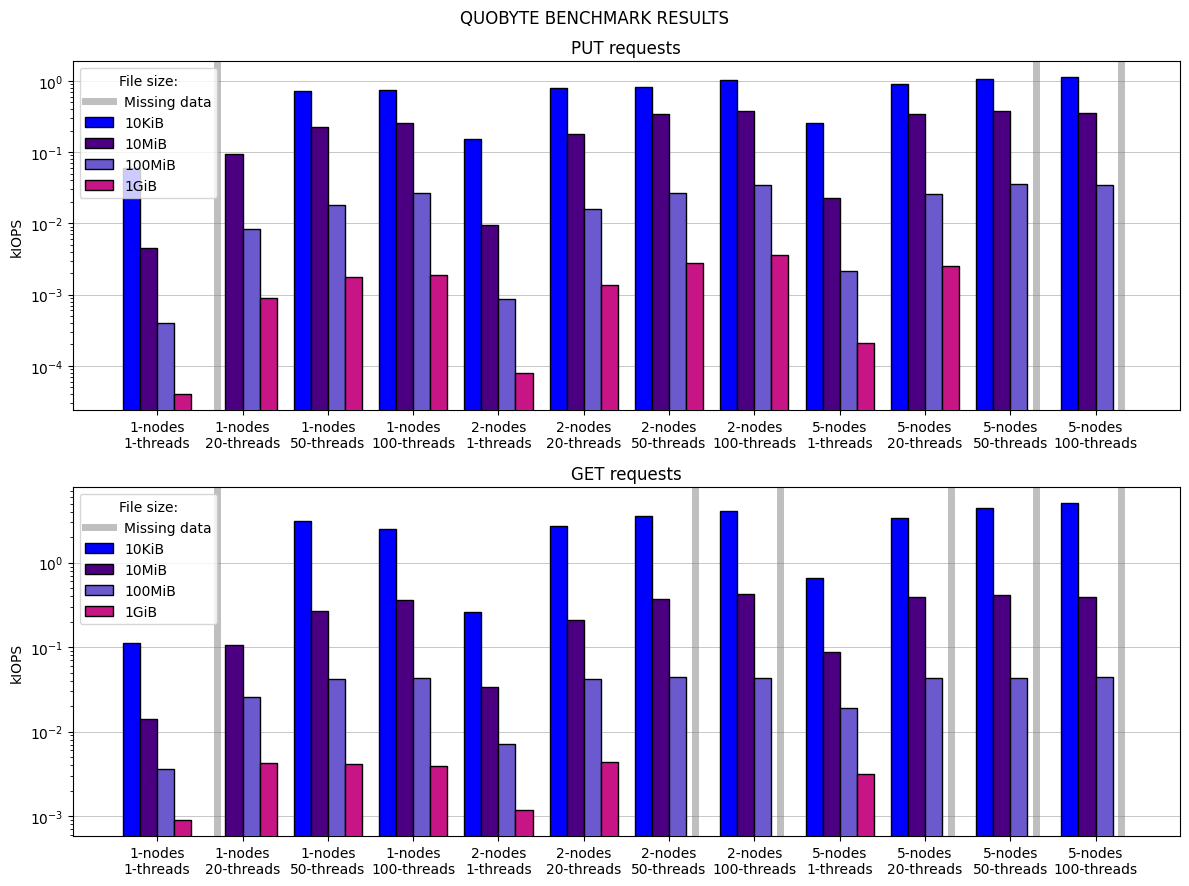

In [4]:
# Code 
vendor = 'quobyte'
fig, axs = plt.subplots(figsize=(12, 9), nrows=2)
fig.suptitle(f'{vendor} benchmark results'.upper())
bar_colours = {"10KiB":"blue", "10MiB":"indigo", "100MiB":"slateblue", "1GiB":"mediumvioletred"}
axs[0].set_title('PUT requests')
axs[0].set_yscale('log')
plot_single_vendor_summary(vendor, 'put', unit='kIOPS', ax=axs[0], bar_colours=bar_colours)
axs[1].set_title('GET requests')
axs[1].set_yscale('log')
plot_single_vendor_summary(vendor, 'get', unit='kIOPS', ax=axs[1], bar_colours=bar_colours)

plt.tight_layout()

### Pure Storage

File size throughput:

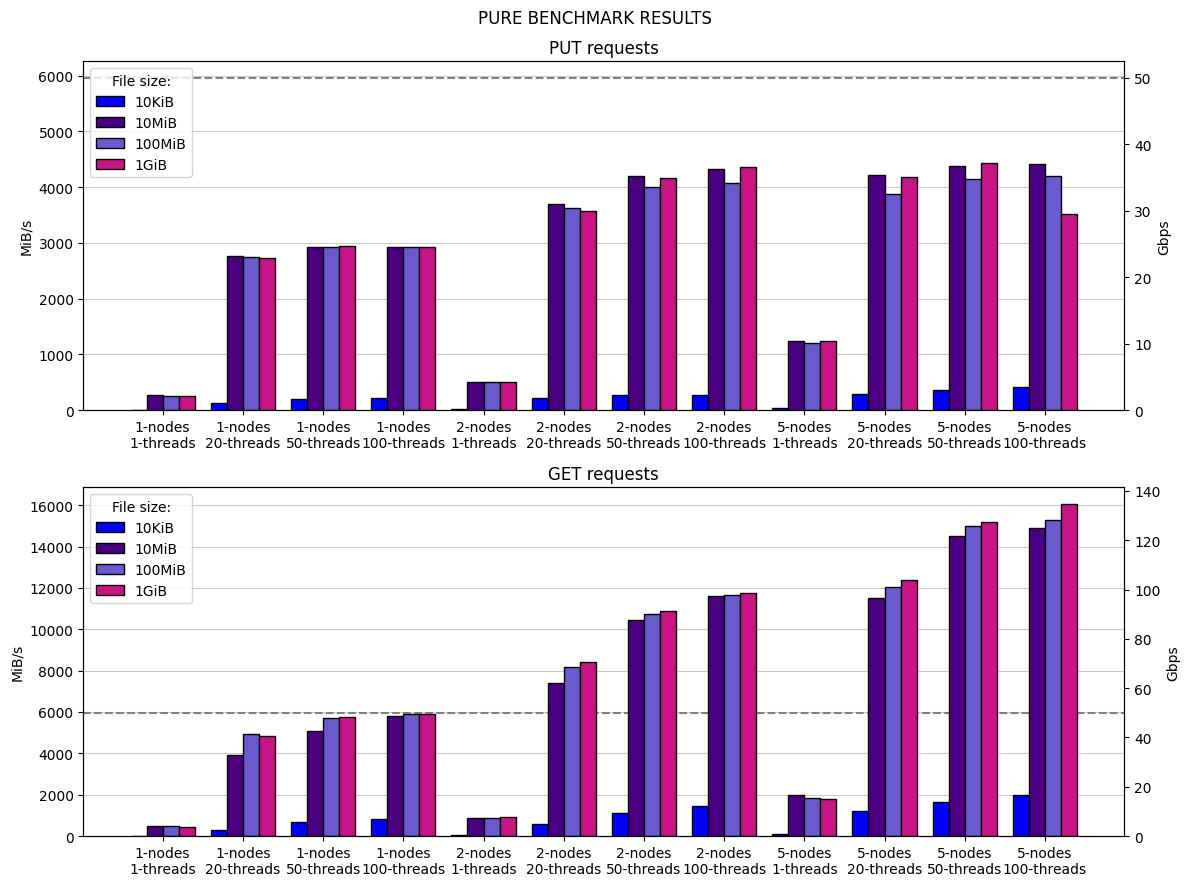

In [5]:
# Code 
vendor = 'pure'
fig, axs = plt.subplots(figsize=(12, 9), nrows=2)
fig.suptitle(f'{vendor} benchmark results'.upper())
bar_colours = {"10KiB":"blue", "10MiB":"indigo", "100MiB":"slateblue", "1GiB":"mediumvioletred"}
axs[0].set_title('PUT requests')
plot_single_vendor_summary(vendor, 'put', ax=axs[0], bar_colours=bar_colours)
axs[1].set_title('GET requests')
plot_single_vendor_summary(vendor, 'get', ax=axs[1], bar_colours=bar_colours)

plt.tight_layout()

Object count throughput:

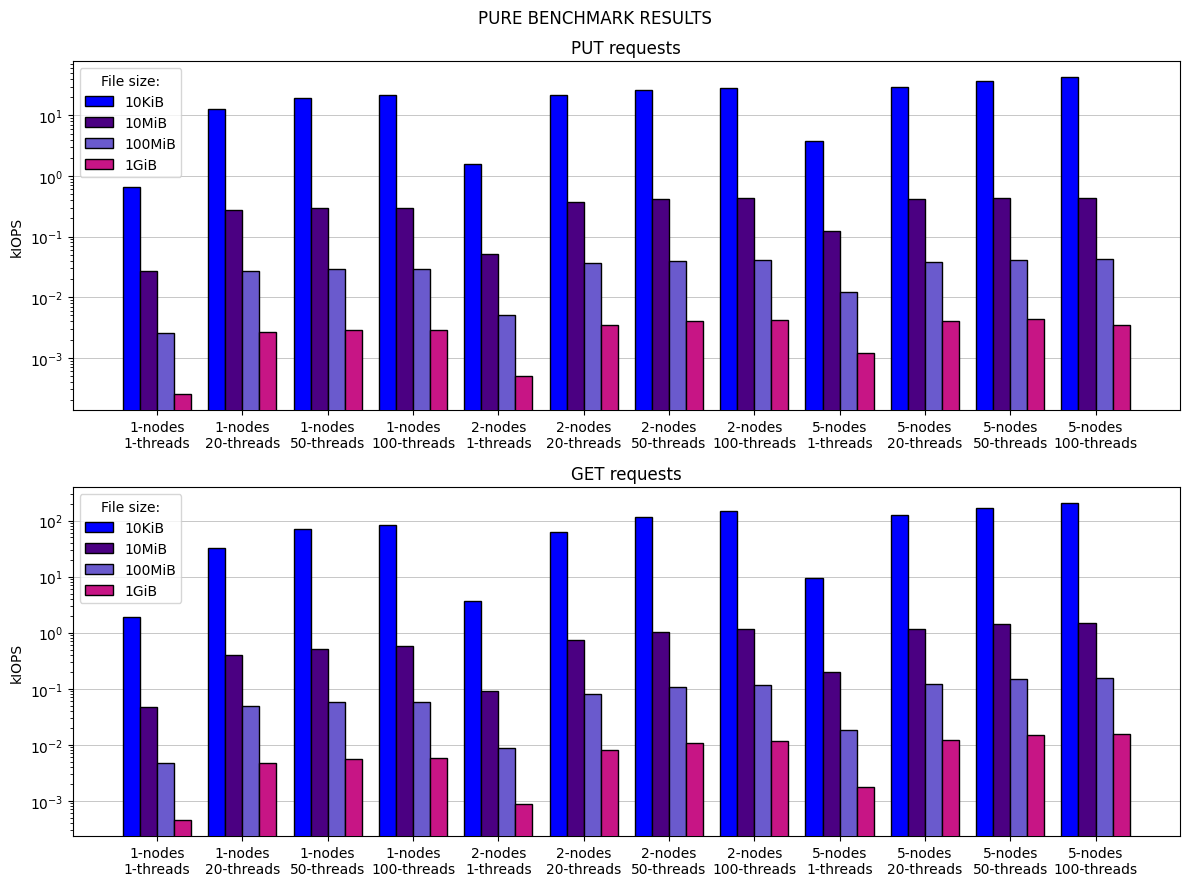

In [6]:
# Code 
vendor = 'pure'
fig, axs = plt.subplots(figsize=(12, 9), nrows=2)
fig.suptitle(f'{vendor} benchmark results'.upper())
bar_colours = {"10KiB":"blue", "10MiB":"indigo", "100MiB":"slateblue", "1GiB":"mediumvioletred"}
axs[0].set_title('PUT requests')
axs[0].set_yscale('log')
plot_single_vendor_summary(vendor, 'put', unit='kIOPS', ax=axs[0], bar_colours=bar_colours)
axs[1].set_title('GET requests')
axs[1].set_yscale('log')
plot_single_vendor_summary(vendor, 'get', unit='kIOPS', ax=axs[1], bar_colours=bar_colours)

plt.tight_layout()

### Caringo

File size throughput:

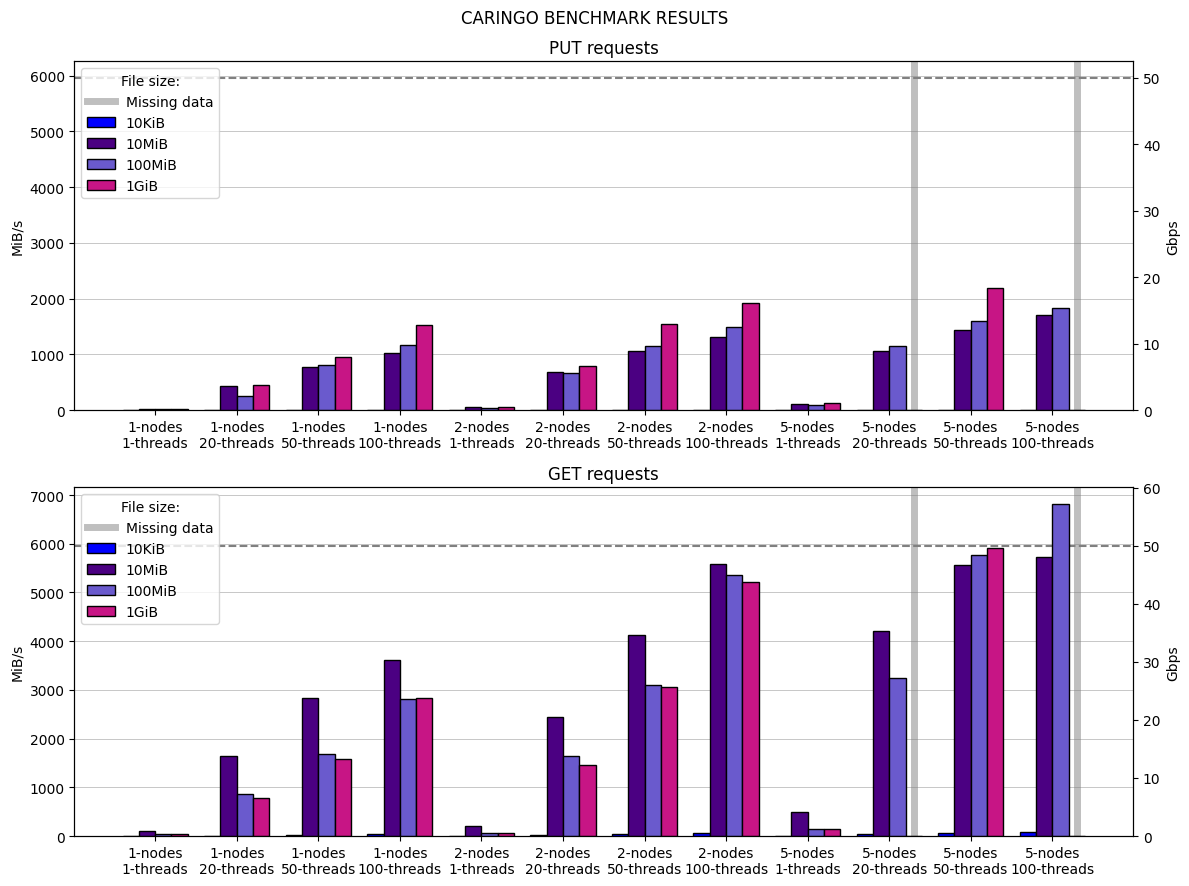

In [8]:
# Code 
vendor = 'caringo'
fig, axs = plt.subplots(figsize=(12, 9), nrows=2)
fig.suptitle(f'{vendor} benchmark results'.upper())
bar_colours = {"10KiB":"blue", "10MiB":"indigo", "100MiB":"slateblue", "1GiB":"mediumvioletred"}
axs[0].set_title('PUT requests')
plot_single_vendor_summary(vendor, 'put', ax=axs[0], bar_colours=bar_colours)
axs[1].set_title('GET requests')
plot_single_vendor_summary(vendor, 'get', ax=axs[1], bar_colours=bar_colours)

plt.tight_layout()

Object count throughput:

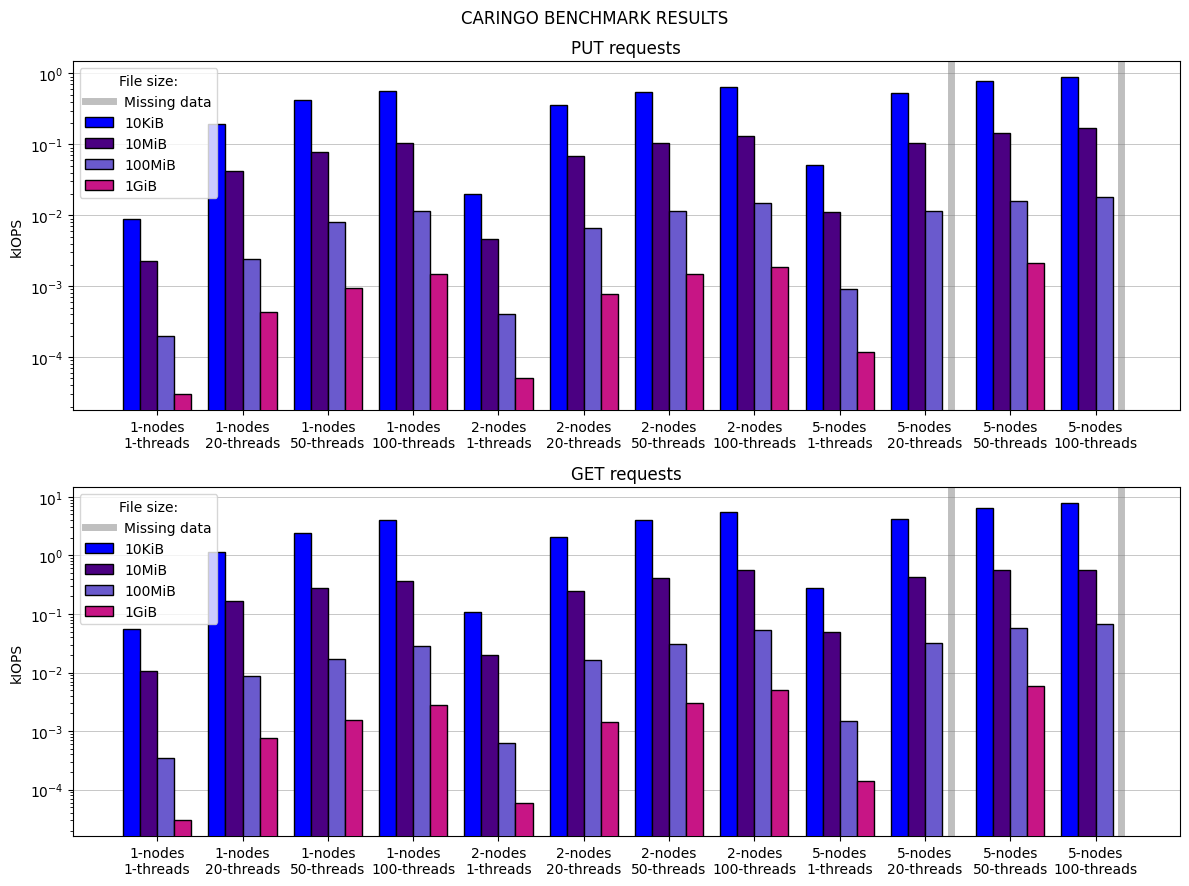

In [9]:
# Code 
vendor = 'caringo'
fig, axs = plt.subplots(figsize=(12, 9), nrows=2)
fig.suptitle(f'{vendor} benchmark results'.upper())
bar_colours = {"10KiB":"blue", "10MiB":"indigo", "100MiB":"slateblue", "1GiB":"mediumvioletred"}
axs[0].set_title('PUT requests')
axs[0].set_yscale('log')
plot_single_vendor_summary(vendor, 'put', unit='kIOPS', ax=axs[0], bar_colours=bar_colours)
axs[1].set_title('GET requests')
axs[1].set_yscale('log')
plot_single_vendor_summary(vendor, 'get', unit='kIOPS', ax=axs[1], bar_colours=bar_colours)

plt.tight_layout()

## Vendor comparison plots

In [10]:
# Code - function defs 

def file_filter(file, vendor, op, nodes, threads, obj_size):
    pattern = f's3-summary.{vendor}-{op}-{nodes}-{threads}-{obj_size}-'
    return (pattern in file.name and file.suffix == '.txt')

def plot_vendor_comparison(
    obj_size, 
    op, 
    unit='MiB/s',
    ax=None,
    bar_colours=None,
    highlight_uplink_speed=True,
    highlight_missing=True,
):
    
    # Load scores
    data_dir = pathlib.Path('./benchmark-runs/')
    scores = {}
    for nodes in [1, 2, 5]:
        for threads in [1, 20, 50, 100]:
            group_key = f'{nodes}-nodes\n{threads}-threads'
            scores[group_key] = {}
            for vendor in ['pure', 'quobyte', 'caringo']:
                # Always use 'get' as op filter since this file also holds 'put' scores
                files = list(filter(
                    lambda f: file_filter(f, vendor, 'get', nodes, threads, obj_size),
                    data_dir.iterdir()
                ))
                if len(files) > 1:
                    raise Exception(
                        f'Ambiguous file filter - {len(files)} files found for:',
                        vendor, 'get', nodes, threads, obj_size,
                        '\nFiles:', files
                    )
                try:
                    scores[group_key][vendor] = parse_text_summary(files[0])[op.upper()]
                except Exception:
                    scores[group_key][vendor] = {'MiB/s': 0, 'kIOPS': 0}
                if unit not in scores[group_key][vendor].keys():
                    scores[group_key][vendor] = {unit: 0}                    
    
    # Wrangle data into plottable format
    groups = list(scores.keys())
    keys = [k for k, v in scores[groups[0]].items() if unit in v.keys()]
    data = {k:[scores[g][k][unit] for g in groups] for k in keys}

    x = np.arange(len(groups))  # the label locations
    width = 1 / (1+len(keys)) # the width of the bars
    multiplier = (1.5 - len(keys)/2)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.grid(axis="y", lw=0.5, zorder=0)
    
    missing_label_set = False
    for i, (k, scores) in enumerate(data.items()):
        offset = width * multiplier
        rects = ax.bar(
            x + offset, 
            scores, 
            width, 
            ec="k", 
            label=k, 
            zorder=3,
            color=(bar_colours[k] if bar_colours is not None else None)
        )
        multiplier += 1
        # Add temporary marker for missing data
        if highlight_missing:
            for i, s in enumerate(scores):
                if s == 0:
                    L = 'Missing data' if not missing_label_set else ''
                    ax.axvline([i+offset], lw=5, c='grey', alpha=0.5, label=L)
                    missing_label_set = True


    # Add some extra stuff
    ax.set_xticks(x + width, groups)
    ax.set_ylabel(unit)
    ax.legend(title='File size:', loc=2)
    if unit == 'MiB/s':
        if highlight_uplink_speed:
            ax.axhline([Gb_to_MiB(50)], label='Single node limit (2x25 Gbps)', c='grey', ls='--')
        # Create second axis with Gbps units
        ax2 = ax.twinx()
        ax2.set_ylim(tuple(map(MiB_to_Gb, ax.get_ylim())))
        ax2.set_ylabel('Gbps')
        
    return ax

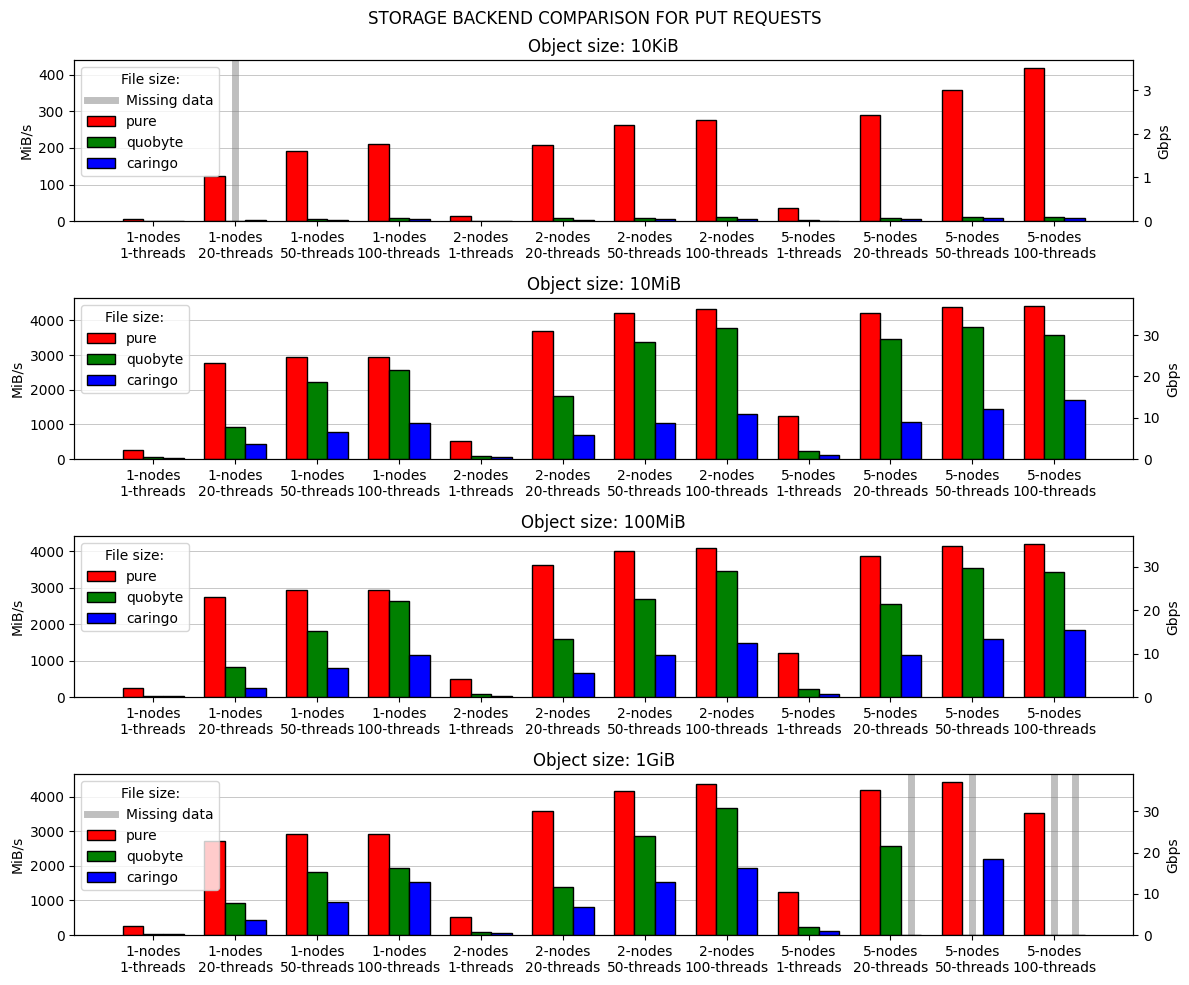

In [11]:
# Code 
fig, axs = plt.subplots(figsize=(12, 10), nrows=4)
bar_colours = {'pure': 'r', 'quobyte': 'g', 'caringo': 'b'}
for i, obj_size in enumerate(['10KiB', '10MiB', '100MiB', '1GiB']):
    axs[i].set_title(f'Object size: {obj_size}')
    plot_vendor_comparison(obj_size, 'put', ax=axs[i], highlight_uplink_speed=False, bar_colours=bar_colours)

fig.suptitle('STORAGE BACKEND COMPARISON FOR PUT REQUESTS')    
fig.tight_layout()

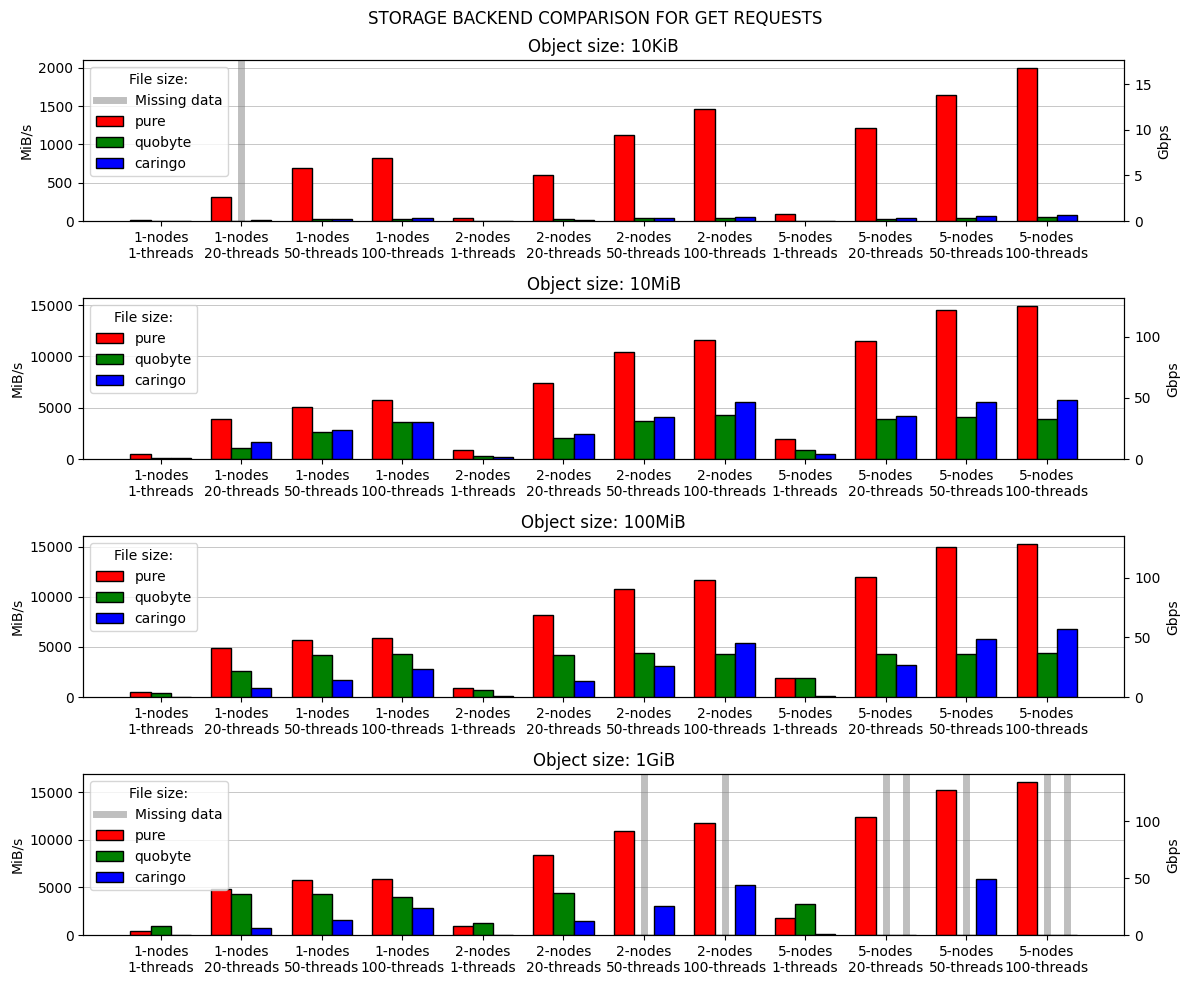

In [12]:
# Code 
fig, axs = plt.subplots(figsize=(12, 10), nrows=4)
bar_colours = {'pure': 'r', 'quobyte': 'g', 'caringo': 'b'}
for i, obj_size in enumerate(['10KiB', '10MiB', '100MiB', '1GiB']):
    axs[i].set_title(f'Object size: {obj_size}')
    plot_vendor_comparison(obj_size, 'get', ax=axs[i], highlight_uplink_speed=False, bar_colours=bar_colours)

fig.suptitle('STORAGE BACKEND COMPARISON FOR GET REQUESTS')    
fig.tight_layout()

## Missing Quobyte data investigation

From the very first Quobyte results plot above (reproduced below for convenience) we can see that there is some missing data for the 5 node, 50/100 thread combinations with large 1GiB object sizes (the 1-node-20-thread-10KiB data is missing for a different reason). It turns out that the reason for this missing data at large object sizes is actually quite interesting, as will be explained in this section.

*Note* - The explanation given here only covers why the Quobyte 5-node 50/100-thread data is missing. Other instances of missing data haven't been fully investigated yet.

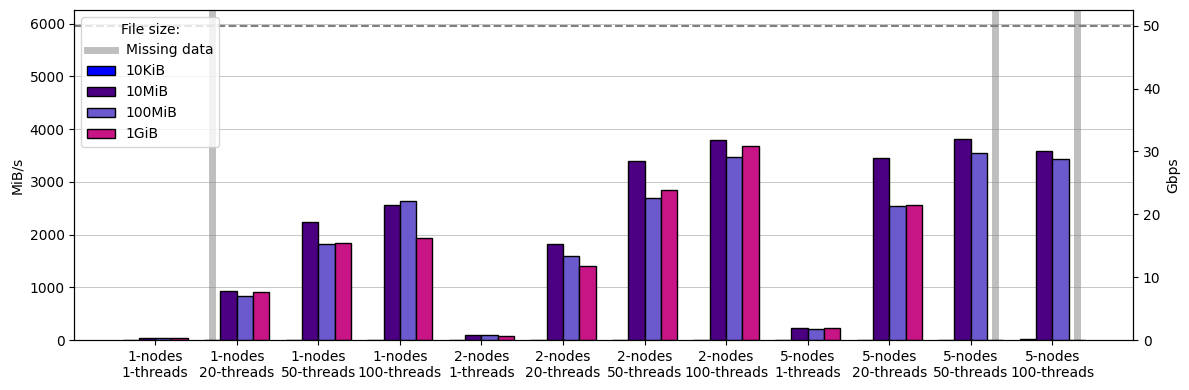

In [14]:
# Code 
fig, ax = plt.subplots(figsize=(12, 4))
bar_colours = {"10KiB":"blue", "10MiB":"indigo", "100MiB":"slateblue", "1GiB":"mediumvioletred"}
plot_single_vendor_summary('quobyte', 'put', ax=ax, bar_colours=bar_colours)
fig.tight_layout()

To understand why this data is missing, we first need to highlight exactly how the `warp` tool runs its post-processing data analysis to produce average throughput scores. As [stated in the warp docs](https://github.com/minio/warp#analysis-data), the analysis process purposefully excludes any 'warm-up' or 'cool-down' sections of benchmark window. It does this by *only* using requests which start *after all threads have completed at least 1 full request* and also ignores requests which occur after any single thread has started it's final request of the benchmark run.

This idea is illustrated graphically in the toy example below, which shows time span for each individual request to the storage API as a red/green/blue horizontal line with the black dots highlighting the points at which one request completes and new request starts. In this example, the analysis window starts as soon as thread 1 has completed its first request (since it's the slowest to complete it's first one) and ends as soon as thread 3 starts its final request (since it's the first to start its final one).

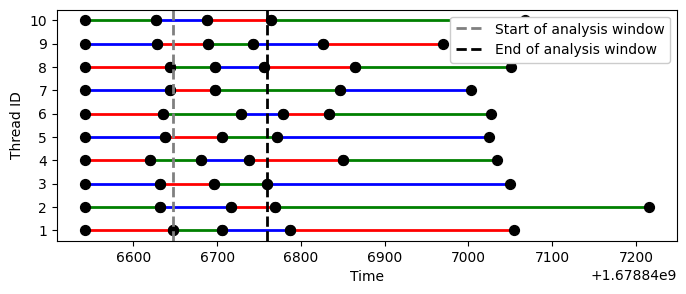

In [15]:
# Code 

from cycler import cycler
custom_colour_cycler = cycler(color=['r', 'g', 'b'])

df, cmd = load_raw_data('benchmark-runs/s3-full.quobyte-get-5-50-1GiB-1000-60s.csv.zst')
df = df[(df.op == 'PUT') & (df.thread < 10)]

window_start = df.groupby('thread').end.first().max().timestamp()
window_end = df.groupby('thread').start.last().min().timestamp()

fig, ax = plt.subplots(figsize=(8, 3))
ax.set_prop_cycle(custom_colour_cycler)
ax.set_ylabel('Thread ID')
ax.set_xlabel('Time')
for thread, requests in df.groupby('thread')[['start', 'end']]:
    for n, r in requests.iterrows():
        ax.plot([r.start.timestamp(), r.end.timestamp()], [thread+1, thread+1], lw=2, ls='-', zorder=-1)        
        ax.scatter([r.start.timestamp(), r.end.timestamp()], [thread+1, thread+1], s=50, c='k')       
ax.axvline([window_start], ls="--", c='grey', lw=2, label="Start of analysis window")
ax.axvline([window_end], ls="--", c='k', lw=2, label="End of analysis window")
ax.set_yticks(range(1, 11))
ax.legend(framealpha=1)
plt.show()

This procedure used by `warp` for choosing an appropriate analysis time window makes sense since it only selects the times where all clients/threads are truely acting concurrently and ignores any start-up time for individual clients/threads.

### Exceptionally slow requests

With this explanation of the internal warp workings in mind, we can now explain why the 5-node-50-thread-100-GiB data is missing from the Quobyte PUT request plot. If we look at the distribution of durations for individual API requests for each thread ('thread' ID here is an amalgamation of node & thread, so thread 51, for example, is the 1st thread on node 2) we get the following:

In [16]:
# Code 
print('Request duration statistics (in seconds) by thread:')
df, cmd = load_raw_data('benchmark-runs/s3-full.quobyte-get-5-50-1GiB-1000-60s.csv.zst')
df = df[(df.op == 'PUT')]
df['duration'] = df.duration_ns / 1e9
(df.groupby('thread')
 .duration
 .describe()
 .sort_values('max')
#  .rename(columns={'mean': 'mean_duration (s)', 'max': 'max (s)'})
)

Request duration statistics (in seconds) by thread:


,count,mean,std,min,25%,50%,75%,max
thread,,,,,,,,
105.0,5.0,62.923060,16.105356,43.227406,52.954744,60.870009,74.142380,83.420760
149.0,5.0,77.690206,9.985521,65.505663,69.811569,78.787877,85.268173,89.077745
84.0,5.0,72.346408,15.787528,52.373975,65.814152,66.584394,87.572917,89.386605
74.0,5.0,76.105024,17.291862,48.843390,69.110789,84.670188,88.426104,89.474651
167.0,7.0,57.169766,25.879192,25.945377,35.369773,62.094809,75.723246,89.962139
...,...,...,...,...,...,...,...,...
155.0,1.0,6021.580310,NaN,6021.580310,6021.580310,6021.580310,6021.580310,6021.580310
153.0,1.0,6063.770708,NaN,6063.770708,6063.770708,6063.770708,6063.770708,6063.770708
147.0,1.0,6088.929108,NaN,6088.929108,6088.929108,6088.929108,6088.929108,6088.929108


The above table has been sorted by the 'max' column which is the maximum time (in seconds) taken for a single PUT request to complete on the corresponding thread. This reveals that there are a handful of threads which take an extremely long time to complete a single request (\~100 minutes), relative to the mean request duration on the quicker threads (\~1 minute).

We can confirm that this is not a specific issue with a single node if we group by node instead of thread, where we see that each node has at least 1 of these extremely slow operations:

In [17]:
# Code 
df, cmd = load_raw_data('benchmark-runs/s3-full.quobyte-get-5-50-1GiB-1000-60s.csv.zst')
df = df[(df.op == 'PUT')]
df['duration'] = df.duration_ns / 1e9
df.groupby('client_id').duration.describe().sort_values('max')

,count,mean,std,min,25%,50%,75%,max
client_id,,,,,,,,
3eO5Sm,200.0,133.602255,415.507606,30.166164,62.066074,84.353223,128.425745,5917.840378
sPvvwx,200.0,157.947584,584.750055,28.967650,62.355935,84.426418,115.738256,6002.459882
OQb49P,200.0,154.740682,587.038511,30.749461,61.440007,83.091980,104.531357,6088.929108
vn8PoT,200.0,218.740424,836.254864,25.945377,61.840554,84.968355,120.979459,6090.571944
k10D3I,200.0,198.331811,722.148550,30.137883,63.912826,85.447682,127.336790,6099.314729


The reason this results in warp analysis procedure failing to produce a calculated throughput is clear if we consider the usable time window for such a run containing a handful of extremely slow requests. Using the same plot format as above (without the black dots for clarity) we see that the *start* of the analysis window (as defined by warp) is actually ***after*** the *end* of the window. Hence the window size is effectively zero so there are no valid requests within the analysis window. Unfortunately, warp simply reports this result as 'too few samples' in the analysis window which is not particularly helpful...

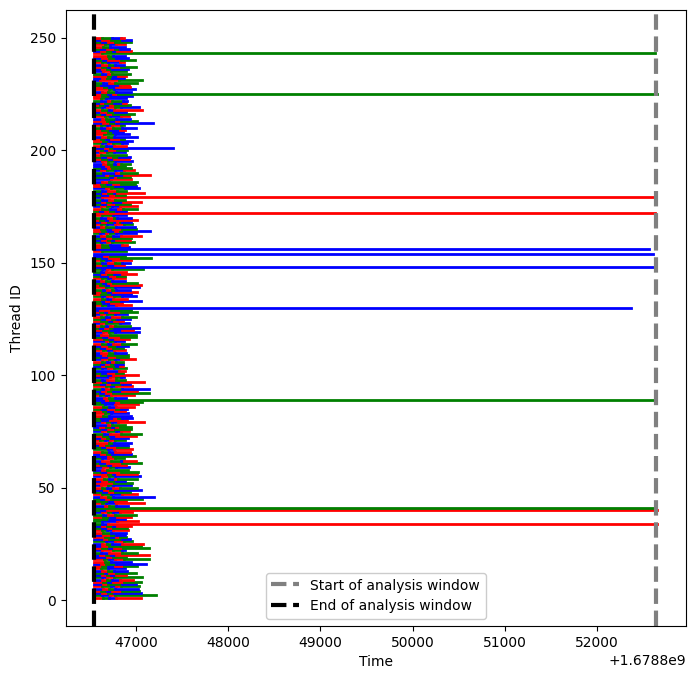

In [18]:
# Code 

from cycler import cycler
custom_colour_cycler = cycler(color=['r', 'g', 'b'])

df, cmd = load_raw_data('benchmark-runs/s3-full.quobyte-get-5-50-1GiB-1000-60s.csv.zst')
df = df[(df.op == 'PUT')]

window_start = df.groupby('thread').end.first().max().timestamp()
window_end = df.groupby('thread').start.last().min().timestamp()

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_prop_cycle(custom_colour_cycler)
ax.set_ylabel('Thread ID')
ax.set_xlabel('Time')
for thread, requests in df.groupby('thread')[['start', 'end']]:
    for n, r in requests.iterrows():
        ax.plot([r.start.timestamp(), r.end.timestamp()], [thread+1, thread+1], lw=2, ls='-', zorder=-1)        
ax.axvline([window_start], ls="--", c='grey', lw=3, label="Start of analysis window")
ax.axvline([window_end], ls="--", c='k', lw=3, label="End of analysis window")
ax.legend(framealpha=1)
plt.show()

The simplest way to solve this is issue directly is to just increase the volume of data uploaded so that all threads remain busy for the full duration of any particularly slow upload occuring simultaneously on other threads; however, this could quickly lead to capacity issues on systems with limited storage.